In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

# Your model and training code here
import warnings
warnings.filterwarnings('ignore')

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/content/drive/MyDrive/emotion/Datasets/Tess'):
  for filename in  filenames:
    paths.append(os.path.join(dirname, filename))
    label = filename.split('_')[-1]
    label = label.split('.')[-2]
    labels.append(label.lower())
  if len(paths) == 2800:
    break
print('Dataset is Loaded')


Dataset is Loaded


In [ ]:
len(paths)

2800

In [ ]:
paths[:5]

['/content/drive/MyDrive/emotion/Datasets/Tess/OAF_neutral/OAF_dodge_neutral.wav',
 '/content/drive/MyDrive/emotion/Datasets/Tess/OAF_neutral/OAF_deep_neutral.wav',
 '/content/drive/MyDrive/emotion/Datasets/Tess/OAF_neutral/OAF_beg_neutral.wav',
 '/content/drive/MyDrive/emotion/Datasets/Tess/OAF_neutral/OAF_calm_neutral.wav',
 '/content/drive/MyDrive/emotion/Datasets/Tess/OAF_neutral/OAF_door_neutral.wav']

In [ ]:
labels[20:50]

['neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral']

In [ ]:
df = pd.DataFrame()
df['audio.paths'] = paths
df['labels'] = labels
df.head()

,audio.paths,labels
0,/content/drive/MyDrive/emotion/Datasets/Tess/O...,neutral
1,/content/drive/MyDrive/emotion/Datasets/Tess/O...,neutral
2,/content/drive/MyDrive/emotion/Datasets/Tess/O...,neutral
3,/content/drive/MyDrive/emotion/Datasets/Tess/O...,neutral
4,/content/drive/MyDrive/emotion/Datasets/Tess/O...,neutral


In [ ]:
df['labels'].value_counts()

,count
labels,
neutral,400
angry,400
fear,400
sad,400
disgust,400
happy,400
ps,400


<Axes: xlabel='labels', ylabel='count'>

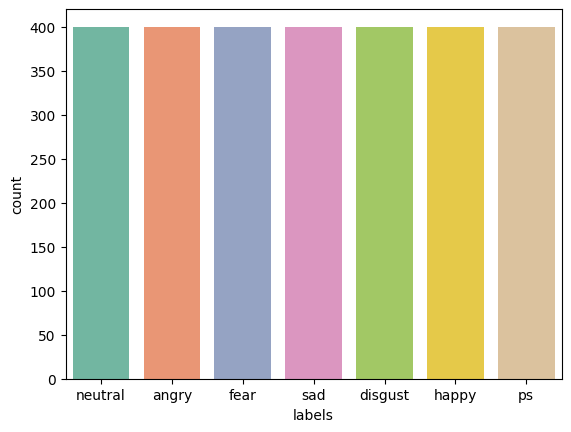

In [ ]:
sns.color_palette("tab10")
sns.countplot(data = df, x = 'labels', palette = "Set2")

In [ ]:
def waveplot(data, sr, emotion):
  plt.figure(figsize =(10,4))
  plt.title(emotion, size = 20)
  librosa.display.waveshow(data, sr = sr)
  plt.show()

def spectogram(data, sr, emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(x))
  plt.figure(figsize =(11,4))
  plt.title(emotion, size = 20)
  librosa.display.specshow(xdb, sr = sr, x_axis = 'time', y_axis = 'hz')
  plt.show()

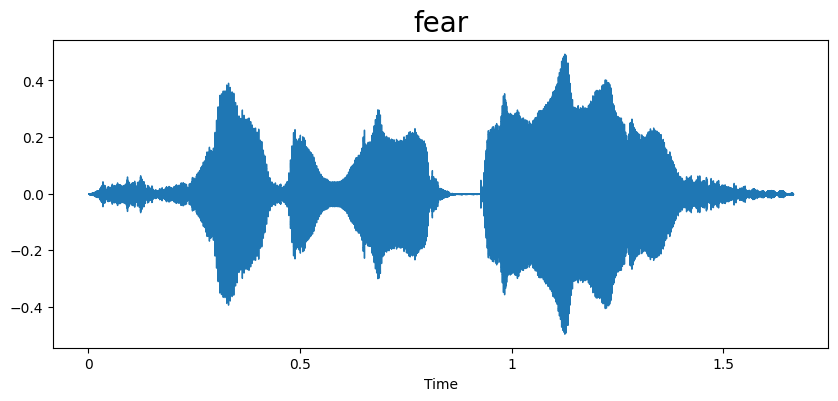

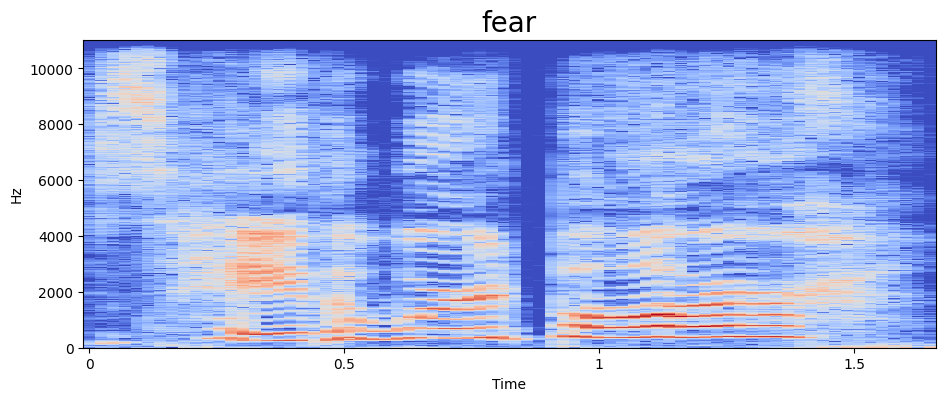

In [ ]:
emotion = 'fear'
path = np.array(df['audio.paths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)

spectogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)
df.head()

,audio.paths,labels
0,/content/drive/MyDrive/emotion/Datasets/Tess/O...,0
1,/content/drive/MyDrive/emotion/Datasets/Tess/O...,0
2,/content/drive/MyDrive/emotion/Datasets/Tess/O...,0
3,/content/drive/MyDrive/emotion/Datasets/Tess/O...,0
4,/content/drive/MyDrive/emotion/Datasets/Tess/O...,0


In [ ]:
class speachEmotionDataset(Dataset):
  def __init__(self, df, processor, max_length = 32000):
    self.df = df
    self.processor = processor
    self.max_length =  max_length

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx) :
    audio_path = self.df.iloc[idx]['audio.paths']
    label = self.df.iloc[idx]['labels']

    # speech, sr = torchaudio.load(audio_path)

    # speech = torchaudio.functional.resample(speech, orig_freq= sr, new_freq=16000)
    # speech = speech.squeeze().numpy()
    speech, sr = librosa.load(audio_path, sr = 16000)
    if len(speech) > self.max_length:
      speech = speech[:self.max_length]
    else:
      speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

    inputs = self.processor(speech, sampling_rate = 16000, return_tensors = 'pt', padding = True, truncat = True, max_length = self.max_length)

    input_values = inputs.input_values.squeeze()
    return{'input_values' : input_values, 'labels': torch.tensor(label, dtype= torch.long)}


In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels = 7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = speachEmotionDataset(train_df, processor)
test_dataset = speachEmotionDataset(test_df, processor)

In [ ]:
train_dataset[0]

{'input_values': tensor([ 0.0022,  0.0002, -0.0031,  ...,  0.0008,  0.0008,  0.0008]),
 'labels': tensor(2)}

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size= 8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= 8, shuffle=False)

In [ ]:
training_args = TrainingArguments(
    output_dir = '/content/drive/MyDrive/emotion/result',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,
    num_train_epochs = 3,
    weight_decay = 0.01,
    report_to=[]
)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metric(pred):
  labels = pred.label_ids
  preds = np.argmax(pred.predictions, axis = 1)
  accuracy = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average= 'weighted')
  return {
     ' accuracy' : accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1
  }

In [ ]:
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset,
    compute_metrics = compute_metric
)
trainer.train()

Epoch,Training Loss,Validation Loss,accuracy,Precision,Recall,F1
1,No log,0.626857,0.991071,0.991223,0.991071,0.991073
2,No log,0.221901,0.998214,0.998237,0.998214,0.998214
3,No log,0.165726,0.998214,0.998237,0.998214,0.998214


TrainOutput(global_step=420, training_loss=0.6492985316685268, metrics={'train_runtime': 2432.4309, 'train_samples_per_second': 2.763, 'train_steps_per_second': 0.173, 'total_flos': 1.2201848064e+17, 'train_loss': 0.6492985316685268, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.1657264530658722, 'eval_ accuracy': 0.9982142857142857, 'eval_precision': 0.9982366071428572, 'eval_recall': 0.9982142857142857, 'eval_f1': 0.9982144235168312, 'eval_runtime': 9.383, 'eval_samples_per_second': 59.683, 'eval_steps_per_second': 3.73, 'epoch': 3.0}


In [ ]:
import random
idx = random.randrange(0, len(test_dataset))
print('original label:', inverse_label_map[int(test_dataset[idx]['labels'])])
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

with torch.no_grad():
  outputs = model(input_values)

logits = outputs.logits

predicted_class = logits.argmax(dim = -1).item()
print('predicted Labels:', inverse_label_map[predicted_class])

original label: fear
predicted Labels: fear


In [ ]:
import random
import torch


correct_predictions = 0
total_predictions = len(test_dataset)


with torch.no_grad():
    for idx in range(total_predictions):
        input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')
        labels = int(test_dataset[idx]['labels'])

        outputs = model(input_values)
        logits = outputs.logits

        predicted_class = logits.argmax(dim=-1).item()

        if predicted_class == labels:
            correct_predictions += 1


accuracy = correct_predictions / total_predictions
print('Accuracy:', accuracy)

Accuracy: 0.9982142857142857


In [ ]:
import random
import torch
from sklearn.metrics import accuracy_score


all_predictions = []
all_labels = []

with torch.no_grad():
    for idx in range(len(test_dataset)):
        input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')
        labels = int(test_dataset[idx]['labels'])

        outputs = model(input_values)
        logits = outputs.logits

        predicted_class = logits.argmax(dim=-1).item()


        all_predictions.append(predicted_class)
        all_labels.append(labels)


accuracy = accuracy_score(all_labels, all_predictions)
print('Accuracy:', accuracy)

Accuracy: 0.9982142857142857


In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/emotion/fine_tuned_model')
# Save the processor
processor.save_pretrained('/content/drive/MyDrive/emotion/fine_tuned_processor')

[]

In [ ]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor

# Load the model
model = Wav2Vec2ForSequenceClassification.from_pretrained('/content/drive/MyDrive/emotion/fine_tuned_model')

# Load the processor
processor = Wav2Vec2Processor.from_pretrained('/content/drive/MyDrive/emotion/fine_tuned_processor')

In [ ]:
import random
import torch

# Ensure your model is on the correct device (CUDA)
model.to('cuda')

# Select a random index from the test dataset
idx = random.randrange(0, len(test_dataset))
print('original label:', inverse_label_map[int(test_dataset[idx]['labels'])])

# Prepare input values and move them to CUDA
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

# Disable gradient calculation for inference
with torch.no_grad():
    outputs = model(input_values)

# Get logits from the model output
logits = outputs.logits

# Determine the predicted class
predicted_class = logits.argmax(dim=-1).item()
print('predicted Labels:', inverse_label_map[predicted_class])

original label: happy
predicted Labels: happy


In [ ]:
import torch
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2Processor
import librosa
import numpy as np

# Mapping of predicted labels to their corresponding emotion labels
inverse_label_map = {
    0: 'neutral',
    1: 'angry',
    2: 'fear',
    3: 'sad',
    4: 'disgust',
    5: 'happy',
    6: 'ps'
}

# Step 1: Load the fine-tuned model and processor
model_path = '/content/drive/MyDrive/emotion/fine_tuned_model'
processor_path = '/content/drive/MyDrive/emotion/fine_tuned_processor'

model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
processor = Wav2Vec2Processor.from_pretrained(processor_path)

# Define max_length based on model's input
MAX_LENGTH = 32000  # Adjust this based on your dataset

# Load and process audio
def load_and_process_audio(audio_path, processor):
    # Load audio file
    speech, sr = librosa.load(audio_path, sr=16000)
    # Process the audio
    inputs = processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncation=True, max_length=MAX_LENGTH)
    return inputs['input_values']

#  Emotion prediction
def predict_emotion(audio_path):
    # Prepare the audio
    input_values = load_and_process_audio(audio_path, processor)
    # Get predictions
    with torch.no_grad():
        logits = model(input_values).logits
    # Get the predicted class ID
    predicted_class_id = torch.argmax(logits, dim=-1).item()
    return predicted_class_id

# Step 4: Run emotion detection
if __name__ == "__main__":
    audio_file_path = '/content/drive/MyDrive/emotion/Datasets/Savee/DC_d09.wav'  #  audio file path
    predicted_emotion_id = predict_emotion(audio_file_path)

    # Map the predicted class ID to the emotion label
    predicted_emotion_label = inverse_label_map.get(predicted_emotion_id, "Unknown")

    # print(f"The predicted emotion class ID is: {predicted_emotion_id}")
    print(f"The predicted emotion label is: {predicted_emotion_label}")

The predicted emotion label is: disgust
